# Import Libraries

In [87]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm
from keras.optimizers import Adam
import pickle
import random

# Looking at the Dataset

In [2]:
import os as os
filename = './Flickr_Data_30k/Flickr_TextData/Flickr30k.token.txt'
file = open(filename)
doc = file.read()

print(doc[:987])

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .
1000092795.jpg#4	Two friends enjoy time spent together .
10002456.jpg#0	Several men in hard hats are operating a giant pulley system .
10002456.jpg#1	Workers look down from up above on a piece of equipment .
10002456.jpg#2	Two men working on a machine wearing hard hats .
10002456.jpg#3	Four men on top of a tall structure .
10002456.jpg#4	Three men on a large rig .
1000268201.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201.jpg#1	A little girl in a pink dress going into a wooden cabin .
1000268201.jpg#2	A little girl climbing the stairs to her playhouse .
1000268201.jpg#3	A little girl climbing into a wooden playhouse
1000268201.jpg#4	A g


In [5]:
descriptions = dict()
for line in tqdm(doc.split('\n')):
    tokens = line.split()
    
    if(len(tokens)==0):
        continue
    
    image_id = tokens[0]
    image_desc = tokens[1:]
    
    image_id = image_id.split('.')[0]
    
    image_desc = ' '.join(image_desc)
    
    if image_id not in descriptions.keys():
        descriptions[image_id] = list()
        
    descriptions[image_id].append(image_desc)
    
descriptions['3431261634']

100%|██████████████████████████████████████████████████████████████████████| 158916/158916 [00:00<00:00, 166660.34it/s]


['Person with a blue and black suit is surfing .',
 'A surfer is being splashed by an ocean wave .',
 'A man in a blue wetsuit surfs .',
 'A surfer in blue rides a wave .',
 'a surfer makes a big splash .']

# Data Cleaning

In [6]:
import string

# line below creates a dictionary, mapping all punctuations to None type
table = str.maketrans('', '', string.punctuation)

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        
        desc = desc.split()
        
        #convert all words to lowercase
        desc = [word.lower() for word in desc]
        
        #remove punctuations from each word
        desc = [word.translate(table) for word in desc]
        
        #removing punctuation marks will create hanging 's' and 'a', remove those
        desc = [word for word in desc if len(word)>1]
        
        #remove words with numbers in them
        desc = [word for word in desc if word.isalpha()]
        
        #restoring back to string
        desc_list[i] = ' '.join(desc)
        
descriptions['3431261634']

['person with blue and black suit is surfing',
 'surfer is being splashed by an ocean wave',
 'man in blue wetsuit surfs',
 'surfer in blue rides wave',
 'surfer makes big splash']

# Loading Dataset

## Loading training dataset

In [7]:
train_images_path = './Flickr_Data_30k/Flickr_TextData/Flickr_30k.trainImages.txt'

file = open(train_images_path)
doc = file.read()

train_image_names = []
for line in doc.split('\n'):
    if(len(line)<1):
        continue
    
    line = line.split('.')[0]
    
    train_image_names.append(line)
    
print(len(train_image_names))

143023


In [8]:
# Below path contains all the images
images = './Flickr_Data_30k/Images/'
# Create a list of all image names in the directory

all_images = os.listdir(images)
len(all_images)

31785

In [9]:
train_image_names = [name for name in train_image_names if name+'.jpg' in all_images]
print(len(train_image_names))

143023


In [10]:
train_data = {}
for key, val in descriptions.items():
    if key in train_image_names:
        for desc in val:
            if key not in train_data.keys():
                train_data[key] = list()
            train_data[key].append('startseq ' + desc + " endseq")
        
print(len(train_data))
print(train_data)

31783


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Loading Validation Data

In [11]:
val_images_path = './Flickr_Data_30k/Flickr_TextData/Flickr_30k.devImages.txt'

file = open(val_images_path)
doc = file.read()

val_image_names = []
for line in doc.split('\n'):
    if(len(line)<1):
        continue
    
    line = line.split('.')[0]
    
    val_image_names.append(line)
    
print(len(val_image_names))

14302


In [12]:
val_image_names = [name for name in val_image_names if name+'.jpg' in all_images]
print(len(val_image_names))

14302


In [13]:
val_data = {}
for key, val in descriptions.items():
    if key in val_image_names:
        for desc in val:
            if key not in val_data.keys():
                val_data[key] = list()
            val_data[key].append('startseq ' + desc + " endseq")
        
print(len(val_data))
print(val_data)

11966


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Loading Test Data

In [14]:
test_images_path = './Flickr_Data_30k/Flickr_TextData/Flickr_30k.testImages.txt'

file = open(test_images_path)
doc = file.read()

test_image_names = []
for line in doc.split('\n'):
    if(len(line)<1):
        continue
    
    line = line.split('.')[0]
    
    test_image_names.append(line)
    
print(len(test_image_names))

1590


In [15]:
test_image_names = [name for name in test_image_names if name+'.jpg' in all_images]
print(len(test_image_names))

1590


In [16]:
test_data = {}
for key, val in descriptions.items():
    if key in test_image_names:
        for desc in val:
            if key not in test_data.keys():
                test_data[key] = list()
            test_data[key].append('startseq ' + desc + " endseq")
        
print(len(test_data))
print(test_data)

1555


{'1000366164': ['startseq two men one in gray shirt one in black shirt standing near stove endseq', 'startseq two guy cooking and joking around with the camera endseq', 'startseq two men in kitchen cooking food on stove endseq', 'startseq two men are at the stove preparing food endseq', 'startseq two men are cooking meal endseq'], '100577935': ['startseq man with goatee in black shirt and white latex gloves is using tattoo gun to place tattoo on someone back endseq', 'startseq man is putting tattoo on another man upper back endseq', 'startseq man with black shirt giving another man tattoo endseq', 'startseq man is putting tattoo on his back endseq', 'startseq man getting tattoo on his back endseq'], '1007129816': ['startseq the man with pierced ears is wearing glasses and an orange hat endseq', 'startseq man with glasses is wearing beer can crocheted hat endseq', 'startseq man with gauges and glasses is wearing blitz hat endseq', 'startseq man in an orange hat starring at something end

# Data Preprocessing

In [17]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size = (299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

In [18]:
inception_model = InceptionV3(weights='imagenet')

In [19]:
cnn_model = Model(inception_model.input, inception_model.layers[-2].output)

In [20]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = cnn_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [22]:
# saving train, val and test encdings to disk

train_encodings = {}
val_encodings = {}
test_encodings = {}

for img in tqdm(train_image_names):
    img = './Flickr_Data_30k/Images/'+img+'.jpg'
    train_encodings[img] = encode(img)
    
for img in tqdm(val_image_names):
    img = './Flickr_Data_30k/Images/'+img+'.jpg'
    val_encodings[img] = encode(img)
    
for img in tqdm(test_image_names):
    img = './Flickr_Data_30k/Images/'+img+'.jpg'
    test_encodings[img] = encode(img)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:46<00:00, 33.87it/s]


In [26]:
with open("./Flickr_Data_30k/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(train_encodings, encoded_pickle)

In [27]:
with open("./Flickr_Data_30k/encoded_val_images.pkl", "wb") as encoded_pickle:
    pickle.dump(val_encodings, encoded_pickle)

In [28]:
with open("./Flickr_Data_30k/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(test_encodings, encoded_pickle)

In [29]:
train_features = load(open("./Flickr_Data_30k/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=31783


In [30]:
val_features = load(open("./Flickr_Data_30k/encoded_val_images.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

Photos: val=11966


In [31]:
test_features = load(open("./Flickr_Data_30k/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1555


In [32]:
# Vocabulary of all unique words in train corpus
# Keeping words having occurence frequency >= 10 in training corpus

all_train_captions = []
for image_id, desc_list in train_data.items():
    for desc in desc_list:
        all_train_captions.append(desc)
        
print("Total train captions: ", len(all_train_captions))

word_count_threshold = 10
word_counts = {}

for desc in all_train_captions:
    for word in desc.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1 # second argument of get is treated as a default, if key
                                                        # is not found

vocab = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print("Vocabulary size: ", len(vocab))

Total train captions:  158915
Vocabulary size:  5437


In [33]:
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    
    ix+=1

In [34]:
vocab_size = len(wordtoix)+1 # 1 added for 0s
print(vocab_size)

5438


In [35]:
# calculating maximum length of captions in training set

max_length = 0
for caption in all_train_captions:
    max_length = max(max_length, len(caption.split(' ')))
    
print(max_length)

74


## Data Generator

We need to implement our own data generator because we need to ensure that each batch contains complete sequence of an image's caption

In [36]:
def data_generator(data, feature_vectors, wordtoix, max_length, num_images):
    X1, X2, y = list(), list(), list()
    n = 0
        
    #Loop over images
    while True:
        for key, desc_list in data.items():
            n += 1
            feature_vector = feature_vectors['./Flickr_Data_30k/Images/'+key+'.jpg']
            
            # Loading all captions for an image
            for desc in desc_list:
                # encoding the description according to wordtoix
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                #Split the caption into sequences of input sequence and target output word
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    
                    #pad this sequence to have length = max_length
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    
                    #output sequence to be categorical
                    out_seq = to_categorical([seq[i]], num_classes = vocab_size)[0]
                    
                    X1.append(feature_vector)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            #yield the batch
            if n == num_images:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

In [37]:
#Load Glove Vectors
embeddings_index = {}
f = open('./glove.840B.300d.txt', encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        continue
    
f.close()
print('Found %s word vectors.' % len(embeddings_index))

2196017it [08:28, 4317.00it/s]


Found 2195884 word vectors.


In [38]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

count=0
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        count+=1

print("Number of 0 vectors: ", count)

Number of 0 vectors:  25


## Model Architecture

In [120]:
input1 = Input((2048,))
fv = Dropout(0.5)(input1)
fv = Dense(256, activation = 'relu')(fv)

input2 = Input((max_length,))
we = Embedding(vocab_size, embedding_dim, mask_zero = True)(input2)
we = Dropout(0.3)(we)
we = LSTM(256, return_sequences = True)(we)
we = LSTM(256)(we)

combined = concatenate([fv, we])
combined = Dense(512, activation = 'relu')(combined)
combined = Dropout(0.2)(combined)
combined = Dense(256, activation = 'relu')(combined)

out = Dense(vocab_size, activation = 'softmax')(combined)

model = Model(inputs = [input1, input2], outputs = out)

In [122]:
print(model.layers[1])

In [123]:
# setting embedding layer weights = glove vector weights
# making the embedding layer un-trainable

model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = True

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 74)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 74, 300)      1631400     input_15[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 74, 300)      0           embedding_7[0][0]                
__________________________________________________________________________________________________
dropout_20

In [124]:
opt = Adam(lr = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [95]:
# model.load_weights('./model_30k_weights_15.h5')

In [125]:
epochs = 5
num_images = 16
steps = len(train_data)//num_images

val_steps = len(val_data)//num_images

In [126]:
for i in range(epochs):
    print("-----------------------------------EPOCH:"+str(i+1)+"-------------------------------------------")
    train_generator = data_generator(train_data, train_features, wordtoix, max_length, num_images)
    val_generator = data_generator(val_data, val_features, wordtoix, max_length, num_images)
    model.fit_generator(train_generator, epochs = 1, steps_per_epoch = steps, verbose = True,
                       validation_data = val_generator, validation_steps = val_steps) # steps per epoch tells how many batches to sample
                                                                                      #  before declaring one epoch

-----------------------------------EPOCH:1-------------------------------------------
Epoch 1/1


 312/1986 [===>..........................] - ETA: 5:25:03 - loss: 8.61 - ETA: 3:07:53 - loss: 8.54 - ETA: 2:21:49 - loss: 8.45 - ETA: 1:59:37 - loss: 8.25 - ETA: 1:46:03 - loss: 7.98 - ETA: 1:36:58 - loss: 7.81 - ETA: 1:30:58 - loss: 7.64 - ETA: 1:25:47 - loss: 7.50 - ETA: 1:22:29 - loss: 7.36 - ETA: 1:20:00 - loss: 7.26 - ETA: 1:16:47 - loss: 7.18 - ETA: 1:14:47 - loss: 7.12 - ETA: 1:12:51 - loss: 7.08 - ETA: 1:11:15 - loss: 7.03 - ETA: 1:09:36 - loss: 6.99 - ETA: 1:08:09 - loss: 6.95 - ETA: 1:07:12 - loss: 6.91 - ETA: 1:06:02 - loss: 6.87 - ETA: 1:05:04 - loss: 6.84 - ETA: 1:04:21 - loss: 6.81 - ETA: 1:03:43 - loss: 6.78 - ETA: 1:03:08 - loss: 6.75 - ETA: 1:02:26 - loss: 6.71 - ETA: 1:01:46 - loss: 6.68 - ETA: 1:01:18 - loss: 6.66 - ETA: 1:00:49 - loss: 6.63 - ETA: 1:00:22 - loss: 6.61 - ETA: 59:56 - loss: 6.5901 - ETA: 59:38 - loss: 6.56 - ETA: 59:21 - loss: 6.55 - ETA: 58:53 - loss: 6.54 - ETA: 58:34 - loss: 6.52 - ETA: 58:20 - loss: 6.51 - ETA: 57:59 - loss: 6.49 - ETA: 57:48 - lo

 626/1986 [========>.....................] - ETA: 43:05 - loss: 5.31 - ETA: 43:04 - loss: 5.30 - ETA: 43:01 - loss: 5.30 - ETA: 42:59 - loss: 5.30 - ETA: 42:58 - loss: 5.30 - ETA: 42:56 - loss: 5.29 - ETA: 42:54 - loss: 5.29 - ETA: 42:52 - loss: 5.29 - ETA: 42:50 - loss: 5.29 - ETA: 42:47 - loss: 5.29 - ETA: 42:46 - loss: 5.28 - ETA: 42:44 - loss: 5.28 - ETA: 42:42 - loss: 5.28 - ETA: 42:41 - loss: 5.28 - ETA: 42:39 - loss: 5.27 - ETA: 42:37 - loss: 5.27 - ETA: 42:35 - loss: 5.27 - ETA: 42:33 - loss: 5.27 - ETA: 42:32 - loss: 5.26 - ETA: 42:30 - loss: 5.26 - ETA: 42:28 - loss: 5.26 - ETA: 42:27 - loss: 5.26 - ETA: 42:25 - loss: 5.26 - ETA: 42:23 - loss: 5.25 - ETA: 42:22 - loss: 5.25 - ETA: 42:20 - loss: 5.25 - ETA: 42:19 - loss: 5.25 - ETA: 42:17 - loss: 5.25 - ETA: 42:16 - loss: 5.24 - ETA: 42:15 - loss: 5.24 - ETA: 42:13 - loss: 5.24 - ETA: 42:11 - loss: 5.24 - ETA: 42:09 - loss: 5.23 - ETA: 42:07 - loss: 5.23 - ETA: 42:06 - loss: 5.23 - ETA: 42:04 - loss: 5.23 - ETA: 42:02 - loss: 

 940/1986 [=============>................] - ETA: 29:32 - loss: 4.85 - ETA: 29:29 - loss: 4.85 - ETA: 29:27 - loss: 4.85 - ETA: 29:24 - loss: 4.85 - ETA: 29:21 - loss: 4.85 - ETA: 29:18 - loss: 4.85 - ETA: 29:15 - loss: 4.85 - ETA: 29:12 - loss: 4.85 - ETA: 29:09 - loss: 4.84 - ETA: 29:06 - loss: 4.84 - ETA: 29:03 - loss: 4.84 - ETA: 29:00 - loss: 4.84 - ETA: 28:57 - loss: 4.84 - ETA: 28:54 - loss: 4.84 - ETA: 28:52 - loss: 4.84 - ETA: 28:49 - loss: 4.84 - ETA: 28:46 - loss: 4.84 - ETA: 28:43 - loss: 4.84 - ETA: 28:40 - loss: 4.84 - ETA: 28:37 - loss: 4.83 - ETA: 28:34 - loss: 4.83 - ETA: 28:32 - loss: 4.83 - ETA: 28:29 - loss: 4.83 - ETA: 28:26 - loss: 4.83 - ETA: 28:23 - loss: 4.83 - ETA: 28:20 - loss: 4.83 - ETA: 28:18 - loss: 4.83 - ETA: 28:15 - loss: 4.83 - ETA: 28:12 - loss: 4.83 - ETA: 28:09 - loss: 4.83 - ETA: 28:07 - loss: 4.83 - ETA: 28:04 - loss: 4.83 - ETA: 28:01 - loss: 4.83 - ETA: 27:58 - loss: 4.82 - ETA: 27:56 - loss: 4.82 - ETA: 27:53 - loss: 4.82 - ETA: 27:50 - loss: 

1254/1986 [=================>............] - ETA: 18:13 - loss: 4.60 - ETA: 18:11 - loss: 4.60 - ETA: 18:10 - loss: 4.60 - ETA: 18:08 - loss: 4.60 - ETA: 18:06 - loss: 4.60 - ETA: 18:05 - loss: 4.60 - ETA: 18:03 - loss: 4.60 - ETA: 18:02 - loss: 4.60 - ETA: 18:00 - loss: 4.60 - ETA: 17:58 - loss: 4.60 - ETA: 17:57 - loss: 4.60 - ETA: 17:55 - loss: 4.60 - ETA: 17:54 - loss: 4.59 - ETA: 17:52 - loss: 4.59 - ETA: 17:51 - loss: 4.59 - ETA: 17:49 - loss: 4.59 - ETA: 17:47 - loss: 4.59 - ETA: 17:46 - loss: 4.59 - ETA: 17:44 - loss: 4.59 - ETA: 17:43 - loss: 4.59 - ETA: 17:41 - loss: 4.59 - ETA: 17:40 - loss: 4.59 - ETA: 17:38 - loss: 4.59 - ETA: 17:36 - loss: 4.59 - ETA: 17:35 - loss: 4.59 - ETA: 17:33 - loss: 4.59 - ETA: 17:32 - loss: 4.59 - ETA: 17:30 - loss: 4.59 - ETA: 17:29 - loss: 4.59 - ETA: 17:27 - loss: 4.58 - ETA: 17:26 - loss: 4.58 - ETA: 17:24 - loss: 4.58 - ETA: 17:22 - loss: 4.58 - ETA: 17:21 - loss: 4.58 - ETA: 17:19 - loss: 4.58 - ETA: 17:18 - loss: 4.58 - ETA: 17:16 - loss: 

1568/1986 [======================>.......] - ETA: 11:13 - loss: 4.46 - ETA: 11:12 - loss: 4.46 - ETA: 11:11 - loss: 4.46 - ETA: 11:10 - loss: 4.46 - ETA: 11:09 - loss: 4.46 - ETA: 11:08 - loss: 4.46 - ETA: 11:07 - loss: 4.46 - ETA: 11:06 - loss: 4.46 - ETA: 11:04 - loss: 4.46 - ETA: 11:03 - loss: 4.46 - ETA: 11:02 - loss: 4.46 - ETA: 11:01 - loss: 4.46 - ETA: 11:00 - loss: 4.46 - ETA: 10:59 - loss: 4.46 - ETA: 10:58 - loss: 4.46 - ETA: 10:57 - loss: 4.46 - ETA: 10:55 - loss: 4.46 - ETA: 10:54 - loss: 4.46 - ETA: 10:53 - loss: 4.46 - ETA: 10:52 - loss: 4.45 - ETA: 10:51 - loss: 4.45 - ETA: 10:50 - loss: 4.45 - ETA: 10:49 - loss: 4.45 - ETA: 10:48 - loss: 4.45 - ETA: 10:47 - loss: 4.45 - ETA: 10:45 - loss: 4.45 - ETA: 10:44 - loss: 4.45 - ETA: 10:43 - loss: 4.45 - ETA: 10:42 - loss: 4.45 - ETA: 10:41 - loss: 4.45 - ETA: 10:40 - loss: 4.45 - ETA: 10:39 - loss: 4.45 - ETA: 10:38 - loss: 4.45 - ETA: 10:37 - loss: 4.45 - ETA: 10:35 - loss: 4.45 - ETA: 10:34 - loss: 4.45 - ETA: 10:33 - loss: 

1882/1986 [===========================>..] - ETA: 5:53 - loss: 4.355 - ETA: 5:52 - loss: 4.354 - ETA: 5:51 - loss: 4.354 - ETA: 5:50 - loss: 4.354 - ETA: 5:49 - loss: 4.353 - ETA: 5:48 - loss: 4.353 - ETA: 5:48 - loss: 4.353 - ETA: 5:47 - loss: 4.352 - ETA: 5:46 - loss: 4.352 - ETA: 5:45 - loss: 4.351 - ETA: 5:44 - loss: 4.351 - ETA: 5:43 - loss: 4.351 - ETA: 5:42 - loss: 4.350 - ETA: 5:41 - loss: 4.350 - ETA: 5:40 - loss: 4.350 - ETA: 5:39 - loss: 4.349 - ETA: 5:38 - loss: 4.349 - ETA: 5:37 - loss: 4.348 - ETA: 5:36 - loss: 4.348 - ETA: 5:36 - loss: 4.348 - ETA: 5:35 - loss: 4.347 - ETA: 5:34 - loss: 4.347 - ETA: 5:33 - loss: 4.347 - ETA: 5:32 - loss: 4.346 - ETA: 5:31 - loss: 4.346 - ETA: 5:30 - loss: 4.346 - ETA: 5:29 - loss: 4.345 - ETA: 5:28 - loss: 4.345 - ETA: 5:27 - loss: 4.345 - ETA: 5:26 - loss: 4.344 - ETA: 5:25 - loss: 4.344 - ETA: 5:25 - loss: 4.344 - ETA: 5:24 - loss: 4.343 - ETA: 5:23 - loss: 4.343 - ETA: 5:22 - loss: 4.342 - ETA: 5:21 - loss: 4.342 - ETA: 5:20 - loss: 4

1986/1986 [==============================] - ETA: 1:22 - loss: 4.290 - ETA: 1:21 - loss: 4.290 - ETA: 1:20 - loss: 4.290 - ETA: 1:20 - loss: 4.290 - ETA: 1:19 - loss: 4.290 - ETA: 1:18 - loss: 4.290 - ETA: 1:17 - loss: 4.289 - ETA: 1:16 - loss: 4.289 - ETA: 1:15 - loss: 4.289 - ETA: 1:15 - loss: 4.289 - ETA: 1:14 - loss: 4.288 - ETA: 1:13 - loss: 4.288 - ETA: 1:12 - loss: 4.288 - ETA: 1:11 - loss: 4.288 - ETA: 1:11 - loss: 4.288 - ETA: 1:10 - loss: 4.288 - ETA: 1:09 - loss: 4.288 - ETA: 1:08 - loss: 4.288 - ETA: 1:07 - loss: 4.287 - ETA: 1:07 - loss: 4.287 - ETA: 1:06 - loss: 4.287 - ETA: 1:05 - loss: 4.287 - ETA: 1:04 - loss: 4.286 - ETA: 1:03 - loss: 4.286 - ETA: 1:03 - loss: 4.286 - ETA: 1:02 - loss: 4.286 - ETA: 1:01 - loss: 4.286 - ETA: 1:00 - loss: 4.285 - ETA: 59s - loss: 4.285 - ETA: 58s - loss: 4.28 - ETA: 58s - loss: 4.28 - ETA: 57s - loss: 4.28 - ETA: 56s - loss: 4.28 - ETA: 55s - loss: 4.28 - ETA: 54s - loss: 4.28 - ETA: 54s - loss: 4.28 - ETA: 53s - loss: 4.28 - ETA: 52s -

 314/1986 [===>..........................] - ETA: 19:06 - loss: 3.78 - ETA: 17:59 - loss: 3.79 - ETA: 17:26 - loss: 3.83 - ETA: 17:12 - loss: 3.79 - ETA: 16:58 - loss: 3.75 - ETA: 16:49 - loss: 3.73 - ETA: 16:48 - loss: 3.73 - ETA: 16:42 - loss: 3.72 - ETA: 16:43 - loss: 3.71 - ETA: 16:49 - loss: 3.74 - ETA: 16:36 - loss: 3.72 - ETA: 16:33 - loss: 3.74 - ETA: 16:30 - loss: 3.73 - ETA: 16:28 - loss: 3.74 - ETA: 16:23 - loss: 3.76 - ETA: 16:17 - loss: 3.75 - ETA: 16:17 - loss: 3.75 - ETA: 16:12 - loss: 3.73 - ETA: 16:09 - loss: 3.74 - ETA: 16:07 - loss: 3.75 - ETA: 16:06 - loss: 3.75 - ETA: 16:06 - loss: 3.74 - ETA: 16:02 - loss: 3.73 - ETA: 15:59 - loss: 3.72 - ETA: 15:58 - loss: 3.72 - ETA: 15:57 - loss: 3.71 - ETA: 15:56 - loss: 3.72 - ETA: 15:55 - loss: 3.72 - ETA: 15:56 - loss: 3.72 - ETA: 15:56 - loss: 3.73 - ETA: 15:52 - loss: 3.73 - ETA: 15:52 - loss: 3.74 - ETA: 15:51 - loss: 3.74 - ETA: 15:50 - loss: 3.74 - ETA: 15:50 - loss: 3.74 - ETA: 15:49 - loss: 3.73 - ETA: 15:49 - loss: 

 628/1986 [========>.....................] - ETA: 13:21 - loss: 3.69 - ETA: 13:21 - loss: 3.69 - ETA: 13:20 - loss: 3.69 - ETA: 13:20 - loss: 3.69 - ETA: 13:19 - loss: 3.69 - ETA: 13:19 - loss: 3.69 - ETA: 13:18 - loss: 3.69 - ETA: 13:17 - loss: 3.69 - ETA: 13:17 - loss: 3.69 - ETA: 13:16 - loss: 3.69 - ETA: 13:16 - loss: 3.68 - ETA: 13:15 - loss: 3.68 - ETA: 13:15 - loss: 3.68 - ETA: 13:14 - loss: 3.68 - ETA: 13:14 - loss: 3.68 - ETA: 13:13 - loss: 3.68 - ETA: 13:13 - loss: 3.68 - ETA: 13:12 - loss: 3.68 - ETA: 13:12 - loss: 3.68 - ETA: 13:11 - loss: 3.68 - ETA: 13:11 - loss: 3.68 - ETA: 13:10 - loss: 3.68 - ETA: 13:10 - loss: 3.68 - ETA: 13:10 - loss: 3.68 - ETA: 13:09 - loss: 3.68 - ETA: 13:09 - loss: 3.68 - ETA: 13:08 - loss: 3.68 - ETA: 13:08 - loss: 3.68 - ETA: 13:07 - loss: 3.68 - ETA: 13:07 - loss: 3.68 - ETA: 13:06 - loss: 3.68 - ETA: 13:06 - loss: 3.68 - ETA: 13:06 - loss: 3.68 - ETA: 13:05 - loss: 3.68 - ETA: 13:05 - loss: 3.68 - ETA: 13:04 - loss: 3.68 - ETA: 13:03 - loss: 

 942/1986 [=============>................] - ETA: 10:48 - loss: 3.63 - ETA: 10:47 - loss: 3.63 - ETA: 10:47 - loss: 3.63 - ETA: 10:46 - loss: 3.63 - ETA: 10:46 - loss: 3.63 - ETA: 10:45 - loss: 3.63 - ETA: 10:45 - loss: 3.63 - ETA: 10:44 - loss: 3.63 - ETA: 10:44 - loss: 3.63 - ETA: 10:43 - loss: 3.63 - ETA: 10:43 - loss: 3.63 - ETA: 10:42 - loss: 3.63 - ETA: 10:42 - loss: 3.63 - ETA: 10:41 - loss: 3.63 - ETA: 10:41 - loss: 3.63 - ETA: 10:40 - loss: 3.63 - ETA: 10:40 - loss: 3.63 - ETA: 10:39 - loss: 3.63 - ETA: 10:39 - loss: 3.63 - ETA: 10:38 - loss: 3.63 - ETA: 10:38 - loss: 3.63 - ETA: 10:37 - loss: 3.63 - ETA: 10:37 - loss: 3.63 - ETA: 10:36 - loss: 3.63 - ETA: 10:36 - loss: 3.63 - ETA: 10:35 - loss: 3.63 - ETA: 10:35 - loss: 3.63 - ETA: 10:34 - loss: 3.63 - ETA: 10:34 - loss: 3.63 - ETA: 10:33 - loss: 3.63 - ETA: 10:33 - loss: 3.63 - ETA: 10:33 - loss: 3.63 - ETA: 10:32 - loss: 3.63 - ETA: 10:32 - loss: 3.63 - ETA: 10:31 - loss: 3.63 - ETA: 10:31 - loss: 3.63 - ETA: 10:30 - loss: 

1256/1986 [=================>............] - ETA: 8:15 - loss: 3.588 - ETA: 8:14 - loss: 3.588 - ETA: 8:14 - loss: 3.587 - ETA: 8:13 - loss: 3.587 - ETA: 8:13 - loss: 3.586 - ETA: 8:12 - loss: 3.586 - ETA: 8:12 - loss: 3.586 - ETA: 8:11 - loss: 3.586 - ETA: 8:11 - loss: 3.586 - ETA: 8:10 - loss: 3.586 - ETA: 8:10 - loss: 3.586 - ETA: 8:09 - loss: 3.586 - ETA: 8:09 - loss: 3.585 - ETA: 8:08 - loss: 3.585 - ETA: 8:08 - loss: 3.585 - ETA: 8:07 - loss: 3.585 - ETA: 8:07 - loss: 3.585 - ETA: 8:06 - loss: 3.585 - ETA: 8:06 - loss: 3.585 - ETA: 8:06 - loss: 3.584 - ETA: 8:05 - loss: 3.585 - ETA: 8:05 - loss: 3.585 - ETA: 8:04 - loss: 3.585 - ETA: 8:04 - loss: 3.585 - ETA: 8:03 - loss: 3.585 - ETA: 8:03 - loss: 3.585 - ETA: 8:02 - loss: 3.584 - ETA: 8:02 - loss: 3.584 - ETA: 8:01 - loss: 3.584 - ETA: 8:01 - loss: 3.584 - ETA: 8:00 - loss: 3.584 - ETA: 8:00 - loss: 3.584 - ETA: 7:59 - loss: 3.584 - ETA: 7:59 - loss: 3.584 - ETA: 7:59 - loss: 3.584 - ETA: 7:58 - loss: 3.584 - ETA: 7:58 - loss: 3

1570/1986 [======================>.......] - ETA: 5:47 - loss: 3.586 - ETA: 5:47 - loss: 3.586 - ETA: 5:46 - loss: 3.586 - ETA: 5:46 - loss: 3.586 - ETA: 5:45 - loss: 3.586 - ETA: 5:45 - loss: 3.586 - ETA: 5:44 - loss: 3.585 - ETA: 5:44 - loss: 3.585 - ETA: 5:44 - loss: 3.585 - ETA: 5:43 - loss: 3.585 - ETA: 5:43 - loss: 3.585 - ETA: 5:42 - loss: 3.585 - ETA: 5:42 - loss: 3.585 - ETA: 5:41 - loss: 3.585 - ETA: 5:41 - loss: 3.585 - ETA: 5:40 - loss: 3.585 - ETA: 5:40 - loss: 3.585 - ETA: 5:39 - loss: 3.584 - ETA: 5:39 - loss: 3.585 - ETA: 5:38 - loss: 3.584 - ETA: 5:38 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:36 - loss: 3.584 - ETA: 5:36 - loss: 3.584 - ETA: 5:35 - loss: 3.584 - ETA: 5:35 - loss: 3.584 - ETA: 5:34 - loss: 3.584 - ETA: 5:34 - loss: 3.584 - ETA: 5:33 - loss: 3.584 - ETA: 5:33 - loss: 3.584 - ETA: 5:32 - loss: 3.585 - ETA: 5:32 - loss: 3.585 - ETA: 5:31 - loss: 3.585 - ETA: 5:31 - loss: 3.584 - ETA: 5:30 - loss: 3

1886/1986 [===========================>..] - ETA: 3:19 - loss: 3.577 - ETA: 3:18 - loss: 3.577 - ETA: 3:18 - loss: 3.577 - ETA: 3:17 - loss: 3.577 - ETA: 3:17 - loss: 3.577 - ETA: 3:16 - loss: 3.577 - ETA: 3:16 - loss: 3.577 - ETA: 3:15 - loss: 3.577 - ETA: 3:15 - loss: 3.577 - ETA: 3:14 - loss: 3.577 - ETA: 3:14 - loss: 3.577 - ETA: 3:13 - loss: 3.576 - ETA: 3:13 - loss: 3.576 - ETA: 3:13 - loss: 3.576 - ETA: 3:12 - loss: 3.576 - ETA: 3:12 - loss: 3.576 - ETA: 3:11 - loss: 3.576 - ETA: 3:11 - loss: 3.576 - ETA: 3:10 - loss: 3.576 - ETA: 3:10 - loss: 3.576 - ETA: 3:09 - loss: 3.576 - ETA: 3:09 - loss: 3.576 - ETA: 3:08 - loss: 3.576 - ETA: 3:08 - loss: 3.576 - ETA: 3:07 - loss: 3.576 - ETA: 3:07 - loss: 3.576 - ETA: 3:06 - loss: 3.576 - ETA: 3:06 - loss: 3.576 - ETA: 3:05 - loss: 3.575 - ETA: 3:05 - loss: 3.575 - ETA: 3:04 - loss: 3.575 - ETA: 3:04 - loss: 3.575 - ETA: 3:03 - loss: 3.575 - ETA: 3:03 - loss: 3.575 - ETA: 3:03 - loss: 3.575 - ETA: 3:02 - loss: 3.575 - ETA: 3:02 - loss: 3

1986/1986 [==============================] - ETA: 47s - loss: 3.58 - ETA: 47s - loss: 3.58 - ETA: 47s - loss: 3.58 - ETA: 46s - loss: 3.58 - ETA: 46s - loss: 3.58 - ETA: 45s - loss: 3.58 - ETA: 45s - loss: 3.58 - ETA: 44s - loss: 3.58 - ETA: 44s - loss: 3.58 - ETA: 43s - loss: 3.58 - ETA: 43s - loss: 3.58 - ETA: 42s - loss: 3.58 - ETA: 42s - loss: 3.58 - ETA: 41s - loss: 3.58 - ETA: 41s - loss: 3.58 - ETA: 40s - loss: 3.58 - ETA: 40s - loss: 3.58 - ETA: 39s - loss: 3.58 - ETA: 39s - loss: 3.58 - ETA: 38s - loss: 3.58 - ETA: 38s - loss: 3.58 - ETA: 37s - loss: 3.58 - ETA: 37s - loss: 3.58 - ETA: 36s - loss: 3.58 - ETA: 36s - loss: 3.58 - ETA: 35s - loss: 3.58 - ETA: 35s - loss: 3.58 - ETA: 34s - loss: 3.58 - ETA: 34s - loss: 3.58 - ETA: 33s - loss: 3.58 - ETA: 33s - loss: 3.58 - ETA: 32s - loss: 3.58 - ETA: 32s - loss: 3.58 - ETA: 32s - loss: 3.58 - ETA: 31s - loss: 3.58 - ETA: 31s - loss: 3.58 - ETA: 30s - loss: 3.58 - ETA: 30s - loss: 3.58 - ETA: 29s - loss: 3.58 - ETA: 29s - loss: 3.

 314/1986 [===>..........................] - ETA: 19:06 - loss: 3.50 - ETA: 17:56 - loss: 3.50 - ETA: 17:20 - loss: 3.54 - ETA: 17:07 - loss: 3.52 - ETA: 16:53 - loss: 3.48 - ETA: 16:46 - loss: 3.46 - ETA: 16:45 - loss: 3.46 - ETA: 16:38 - loss: 3.44 - ETA: 16:40 - loss: 3.44 - ETA: 16:45 - loss: 3.47 - ETA: 16:32 - loss: 3.45 - ETA: 16:30 - loss: 3.47 - ETA: 16:27 - loss: 3.45 - ETA: 16:25 - loss: 3.45 - ETA: 16:20 - loss: 3.47 - ETA: 16:14 - loss: 3.47 - ETA: 16:14 - loss: 3.47 - ETA: 16:10 - loss: 3.45 - ETA: 16:08 - loss: 3.46 - ETA: 16:06 - loss: 3.46 - ETA: 16:06 - loss: 3.46 - ETA: 16:05 - loss: 3.45 - ETA: 16:02 - loss: 3.45 - ETA: 15:59 - loss: 3.43 - ETA: 15:58 - loss: 3.43 - ETA: 15:57 - loss: 3.43 - ETA: 15:56 - loss: 3.43 - ETA: 15:55 - loss: 3.43 - ETA: 15:55 - loss: 3.44 - ETA: 15:55 - loss: 3.44 - ETA: 15:52 - loss: 3.45 - ETA: 15:51 - loss: 3.45 - ETA: 15:51 - loss: 3.45 - ETA: 15:50 - loss: 3.45 - ETA: 15:50 - loss: 3.46 - ETA: 15:49 - loss: 3.45 - ETA: 15:49 - loss: 

 628/1986 [========>.....................] - ETA: 13:21 - loss: 3.43 - ETA: 13:21 - loss: 3.43 - ETA: 13:20 - loss: 3.43 - ETA: 13:20 - loss: 3.43 - ETA: 13:19 - loss: 3.43 - ETA: 13:19 - loss: 3.43 - ETA: 13:18 - loss: 3.43 - ETA: 13:17 - loss: 3.43 - ETA: 13:17 - loss: 3.43 - ETA: 13:16 - loss: 3.43 - ETA: 13:16 - loss: 3.43 - ETA: 13:15 - loss: 3.43 - ETA: 13:15 - loss: 3.43 - ETA: 13:15 - loss: 3.43 - ETA: 13:14 - loss: 3.43 - ETA: 13:13 - loss: 3.43 - ETA: 13:13 - loss: 3.43 - ETA: 13:12 - loss: 3.43 - ETA: 13:12 - loss: 3.43 - ETA: 13:11 - loss: 3.43 - ETA: 13:11 - loss: 3.43 - ETA: 13:10 - loss: 3.43 - ETA: 13:10 - loss: 3.43 - ETA: 13:10 - loss: 3.43 - ETA: 13:09 - loss: 3.42 - ETA: 13:09 - loss: 3.43 - ETA: 13:08 - loss: 3.42 - ETA: 13:08 - loss: 3.43 - ETA: 13:07 - loss: 3.42 - ETA: 13:07 - loss: 3.42 - ETA: 13:06 - loss: 3.42 - ETA: 13:06 - loss: 3.42 - ETA: 13:05 - loss: 3.42 - ETA: 13:05 - loss: 3.42 - ETA: 13:04 - loss: 3.42 - ETA: 13:04 - loss: 3.42 - ETA: 13:03 - loss: 

 942/1986 [=============>................] - ETA: 10:48 - loss: 3.39 - ETA: 10:47 - loss: 3.39 - ETA: 10:47 - loss: 3.39 - ETA: 10:46 - loss: 3.39 - ETA: 10:46 - loss: 3.39 - ETA: 10:45 - loss: 3.39 - ETA: 10:45 - loss: 3.39 - ETA: 10:44 - loss: 3.39 - ETA: 10:44 - loss: 3.39 - ETA: 10:43 - loss: 3.39 - ETA: 10:43 - loss: 3.39 - ETA: 10:42 - loss: 3.39 - ETA: 10:42 - loss: 3.39 - ETA: 10:41 - loss: 3.39 - ETA: 10:41 - loss: 3.39 - ETA: 10:40 - loss: 3.39 - ETA: 10:40 - loss: 3.39 - ETA: 10:39 - loss: 3.39 - ETA: 10:39 - loss: 3.39 - ETA: 10:38 - loss: 3.39 - ETA: 10:38 - loss: 3.39 - ETA: 10:37 - loss: 3.39 - ETA: 10:37 - loss: 3.39 - ETA: 10:36 - loss: 3.39 - ETA: 10:36 - loss: 3.39 - ETA: 10:35 - loss: 3.39 - ETA: 10:35 - loss: 3.39 - ETA: 10:34 - loss: 3.39 - ETA: 10:34 - loss: 3.39 - ETA: 10:33 - loss: 3.39 - ETA: 10:33 - loss: 3.39 - ETA: 10:33 - loss: 3.39 - ETA: 10:32 - loss: 3.39 - ETA: 10:32 - loss: 3.39 - ETA: 10:31 - loss: 3.39 - ETA: 10:31 - loss: 3.39 - ETA: 10:30 - loss: 

1256/1986 [=================>............] - ETA: 8:16 - loss: 3.362 - ETA: 8:15 - loss: 3.361 - ETA: 8:14 - loss: 3.361 - ETA: 8:14 - loss: 3.361 - ETA: 8:14 - loss: 3.361 - ETA: 8:13 - loss: 3.360 - ETA: 8:13 - loss: 3.360 - ETA: 8:12 - loss: 3.360 - ETA: 8:12 - loss: 3.360 - ETA: 8:11 - loss: 3.360 - ETA: 8:11 - loss: 3.360 - ETA: 8:10 - loss: 3.360 - ETA: 8:10 - loss: 3.360 - ETA: 8:09 - loss: 3.360 - ETA: 8:09 - loss: 3.360 - ETA: 8:08 - loss: 3.360 - ETA: 8:08 - loss: 3.359 - ETA: 8:07 - loss: 3.359 - ETA: 8:07 - loss: 3.360 - ETA: 8:06 - loss: 3.359 - ETA: 8:06 - loss: 3.360 - ETA: 8:05 - loss: 3.360 - ETA: 8:05 - loss: 3.360 - ETA: 8:04 - loss: 3.360 - ETA: 8:04 - loss: 3.360 - ETA: 8:04 - loss: 3.360 - ETA: 8:03 - loss: 3.360 - ETA: 8:03 - loss: 3.360 - ETA: 8:02 - loss: 3.359 - ETA: 8:02 - loss: 3.359 - ETA: 8:01 - loss: 3.359 - ETA: 8:01 - loss: 3.359 - ETA: 8:00 - loss: 3.359 - ETA: 8:00 - loss: 3.359 - ETA: 7:59 - loss: 3.359 - ETA: 7:59 - loss: 3.359 - ETA: 7:58 - loss: 3

1570/1986 [======================>.......] - ETA: 5:47 - loss: 3.372 - ETA: 5:47 - loss: 3.372 - ETA: 5:46 - loss: 3.372 - ETA: 5:46 - loss: 3.372 - ETA: 5:45 - loss: 3.372 - ETA: 5:45 - loss: 3.372 - ETA: 5:45 - loss: 3.372 - ETA: 5:44 - loss: 3.372 - ETA: 5:44 - loss: 3.372 - ETA: 5:43 - loss: 3.372 - ETA: 5:43 - loss: 3.372 - ETA: 5:42 - loss: 3.372 - ETA: 5:42 - loss: 3.372 - ETA: 5:41 - loss: 3.372 - ETA: 5:41 - loss: 3.372 - ETA: 5:40 - loss: 3.372 - ETA: 5:40 - loss: 3.372 - ETA: 5:39 - loss: 3.372 - ETA: 5:39 - loss: 3.372 - ETA: 5:38 - loss: 3.372 - ETA: 5:38 - loss: 3.372 - ETA: 5:38 - loss: 3.372 - ETA: 5:37 - loss: 3.372 - ETA: 5:37 - loss: 3.372 - ETA: 5:36 - loss: 3.372 - ETA: 5:36 - loss: 3.372 - ETA: 5:35 - loss: 3.371 - ETA: 5:35 - loss: 3.371 - ETA: 5:34 - loss: 3.371 - ETA: 5:34 - loss: 3.371 - ETA: 5:33 - loss: 3.372 - ETA: 5:33 - loss: 3.372 - ETA: 5:32 - loss: 3.372 - ETA: 5:32 - loss: 3.372 - ETA: 5:31 - loss: 3.372 - ETA: 5:31 - loss: 3.372 - ETA: 5:31 - loss: 3

1886/1986 [===========================>..] - ETA: 3:19 - loss: 3.376 - ETA: 3:18 - loss: 3.376 - ETA: 3:18 - loss: 3.376 - ETA: 3:17 - loss: 3.376 - ETA: 3:17 - loss: 3.376 - ETA: 3:16 - loss: 3.376 - ETA: 3:16 - loss: 3.376 - ETA: 3:15 - loss: 3.376 - ETA: 3:15 - loss: 3.376 - ETA: 3:14 - loss: 3.376 - ETA: 3:14 - loss: 3.376 - ETA: 3:14 - loss: 3.376 - ETA: 3:13 - loss: 3.376 - ETA: 3:13 - loss: 3.376 - ETA: 3:12 - loss: 3.376 - ETA: 3:12 - loss: 3.376 - ETA: 3:11 - loss: 3.376 - ETA: 3:11 - loss: 3.376 - ETA: 3:10 - loss: 3.376 - ETA: 3:10 - loss: 3.376 - ETA: 3:09 - loss: 3.376 - ETA: 3:09 - loss: 3.376 - ETA: 3:08 - loss: 3.375 - ETA: 3:08 - loss: 3.376 - ETA: 3:07 - loss: 3.375 - ETA: 3:07 - loss: 3.376 - ETA: 3:06 - loss: 3.376 - ETA: 3:06 - loss: 3.376 - ETA: 3:05 - loss: 3.376 - ETA: 3:05 - loss: 3.375 - ETA: 3:04 - loss: 3.375 - ETA: 3:04 - loss: 3.375 - ETA: 3:03 - loss: 3.375 - ETA: 3:03 - loss: 3.375 - ETA: 3:03 - loss: 3.376 - ETA: 3:02 - loss: 3.376 - ETA: 3:02 - loss: 3

1986/1986 [==============================] - ETA: 48s - loss: 3.39 - ETA: 47s - loss: 3.39 - ETA: 47s - loss: 3.39 - ETA: 46s - loss: 3.39 - ETA: 46s - loss: 3.39 - ETA: 45s - loss: 3.39 - ETA: 45s - loss: 3.39 - ETA: 44s - loss: 3.39 - ETA: 44s - loss: 3.39 - ETA: 43s - loss: 3.39 - ETA: 43s - loss: 3.39 - ETA: 42s - loss: 3.39 - ETA: 42s - loss: 3.39 - ETA: 41s - loss: 3.39 - ETA: 41s - loss: 3.39 - ETA: 40s - loss: 3.39 - ETA: 40s - loss: 3.39 - ETA: 39s - loss: 3.39 - ETA: 39s - loss: 3.39 - ETA: 38s - loss: 3.39 - ETA: 38s - loss: 3.39 - ETA: 37s - loss: 3.39 - ETA: 37s - loss: 3.39 - ETA: 36s - loss: 3.39 - ETA: 36s - loss: 3.39 - ETA: 35s - loss: 3.39 - ETA: 35s - loss: 3.39 - ETA: 34s - loss: 3.39 - ETA: 34s - loss: 3.39 - ETA: 33s - loss: 3.39 - ETA: 33s - loss: 3.39 - ETA: 33s - loss: 3.39 - ETA: 32s - loss: 3.39 - ETA: 32s - loss: 3.39 - ETA: 31s - loss: 3.39 - ETA: 31s - loss: 3.39 - ETA: 30s - loss: 3.39 - ETA: 30s - loss: 3.39 - ETA: 29s - loss: 3.39 - ETA: 29s - loss: 3.

 314/1986 [===>..........................] - ETA: 19:08 - loss: 3.35 - ETA: 17:48 - loss: 3.37 - ETA: 17:22 - loss: 3.42 - ETA: 17:09 - loss: 3.40 - ETA: 16:56 - loss: 3.36 - ETA: 16:49 - loss: 3.33 - ETA: 16:49 - loss: 3.32 - ETA: 16:47 - loss: 3.31 - ETA: 16:48 - loss: 3.31 - ETA: 16:53 - loss: 3.33 - ETA: 16:39 - loss: 3.31 - ETA: 16:36 - loss: 3.32 - ETA: 16:32 - loss: 3.31 - ETA: 16:31 - loss: 3.31 - ETA: 16:26 - loss: 3.33 - ETA: 16:20 - loss: 3.32 - ETA: 16:23 - loss: 3.32 - ETA: 16:21 - loss: 3.30 - ETA: 16:18 - loss: 3.31 - ETA: 16:16 - loss: 3.32 - ETA: 16:16 - loss: 3.31 - ETA: 16:15 - loss: 3.31 - ETA: 16:11 - loss: 3.30 - ETA: 16:07 - loss: 3.29 - ETA: 16:07 - loss: 3.29 - ETA: 16:05 - loss: 3.28 - ETA: 16:04 - loss: 3.29 - ETA: 16:04 - loss: 3.29 - ETA: 16:04 - loss: 3.30 - ETA: 16:04 - loss: 3.30 - ETA: 16:02 - loss: 3.31 - ETA: 16:01 - loss: 3.32 - ETA: 16:00 - loss: 3.32 - ETA: 15:59 - loss: 3.31 - ETA: 15:59 - loss: 3.32 - ETA: 15:57 - loss: 3.31 - ETA: 15:57 - loss: 

 628/1986 [========>.....................] - ETA: 13:25 - loss: 3.30 - ETA: 13:25 - loss: 3.30 - ETA: 13:24 - loss: 3.30 - ETA: 13:24 - loss: 3.30 - ETA: 13:23 - loss: 3.30 - ETA: 13:23 - loss: 3.30 - ETA: 13:22 - loss: 3.30 - ETA: 13:21 - loss: 3.30 - ETA: 13:21 - loss: 3.30 - ETA: 13:20 - loss: 3.29 - ETA: 13:20 - loss: 3.29 - ETA: 13:19 - loss: 3.29 - ETA: 13:19 - loss: 3.29 - ETA: 13:18 - loss: 3.29 - ETA: 13:18 - loss: 3.29 - ETA: 13:17 - loss: 3.29 - ETA: 13:17 - loss: 3.29 - ETA: 13:16 - loss: 3.29 - ETA: 13:16 - loss: 3.29 - ETA: 13:15 - loss: 3.29 - ETA: 13:15 - loss: 3.29 - ETA: 13:14 - loss: 3.29 - ETA: 13:14 - loss: 3.29 - ETA: 13:13 - loss: 3.29 - ETA: 13:13 - loss: 3.29 - ETA: 13:12 - loss: 3.29 - ETA: 13:12 - loss: 3.29 - ETA: 13:12 - loss: 3.29 - ETA: 13:11 - loss: 3.29 - ETA: 13:11 - loss: 3.29 - ETA: 13:10 - loss: 3.29 - ETA: 13:09 - loss: 3.29 - ETA: 13:09 - loss: 3.29 - ETA: 13:08 - loss: 3.29 - ETA: 13:08 - loss: 3.29 - ETA: 13:07 - loss: 3.29 - ETA: 13:07 - loss: 

 942/1986 [=============>................] - ETA: 10:49 - loss: 3.26 - ETA: 10:49 - loss: 3.26 - ETA: 10:48 - loss: 3.26 - ETA: 10:48 - loss: 3.26 - ETA: 10:47 - loss: 3.26 - ETA: 10:47 - loss: 3.26 - ETA: 10:46 - loss: 3.26 - ETA: 10:46 - loss: 3.26 - ETA: 10:45 - loss: 3.26 - ETA: 10:45 - loss: 3.26 - ETA: 10:44 - loss: 3.26 - ETA: 10:44 - loss: 3.26 - ETA: 10:43 - loss: 3.26 - ETA: 10:43 - loss: 3.26 - ETA: 10:42 - loss: 3.26 - ETA: 10:42 - loss: 3.26 - ETA: 10:41 - loss: 3.26 - ETA: 10:40 - loss: 3.26 - ETA: 10:40 - loss: 3.26 - ETA: 10:40 - loss: 3.26 - ETA: 10:39 - loss: 3.26 - ETA: 10:38 - loss: 3.26 - ETA: 10:38 - loss: 3.26 - ETA: 10:38 - loss: 3.26 - ETA: 10:37 - loss: 3.26 - ETA: 10:37 - loss: 3.26 - ETA: 10:36 - loss: 3.26 - ETA: 10:36 - loss: 3.26 - ETA: 10:35 - loss: 3.26 - ETA: 10:35 - loss: 3.26 - ETA: 10:34 - loss: 3.26 - ETA: 10:34 - loss: 3.26 - ETA: 10:33 - loss: 3.26 - ETA: 10:33 - loss: 3.26 - ETA: 10:32 - loss: 3.26 - ETA: 10:32 - loss: 3.26 - ETA: 10:31 - loss: 

1256/1986 [=================>............] - ETA: 8:15 - loss: 3.241 - ETA: 8:15 - loss: 3.241 - ETA: 8:14 - loss: 3.240 - ETA: 8:14 - loss: 3.240 - ETA: 8:13 - loss: 3.240 - ETA: 8:13 - loss: 3.240 - ETA: 8:12 - loss: 3.240 - ETA: 8:12 - loss: 3.239 - ETA: 8:11 - loss: 3.240 - ETA: 8:11 - loss: 3.240 - ETA: 8:10 - loss: 3.239 - ETA: 8:10 - loss: 3.239 - ETA: 8:09 - loss: 3.239 - ETA: 8:09 - loss: 3.239 - ETA: 8:08 - loss: 3.239 - ETA: 8:08 - loss: 3.239 - ETA: 8:07 - loss: 3.239 - ETA: 8:07 - loss: 3.239 - ETA: 8:07 - loss: 3.239 - ETA: 8:06 - loss: 3.239 - ETA: 8:06 - loss: 3.239 - ETA: 8:05 - loss: 3.239 - ETA: 8:05 - loss: 3.239 - ETA: 8:04 - loss: 3.239 - ETA: 8:04 - loss: 3.239 - ETA: 8:03 - loss: 3.239 - ETA: 8:03 - loss: 3.239 - ETA: 8:02 - loss: 3.239 - ETA: 8:02 - loss: 3.239 - ETA: 8:01 - loss: 3.239 - ETA: 8:01 - loss: 3.239 - ETA: 8:00 - loss: 3.239 - ETA: 8:00 - loss: 3.239 - ETA: 7:59 - loss: 3.239 - ETA: 7:59 - loss: 3.239 - ETA: 7:58 - loss: 3.239 - ETA: 7:58 - loss: 3

1570/1986 [======================>.......] - ETA: 5:48 - loss: 3.256 - ETA: 5:47 - loss: 3.256 - ETA: 5:47 - loss: 3.256 - ETA: 5:46 - loss: 3.256 - ETA: 5:46 - loss: 3.256 - ETA: 5:45 - loss: 3.256 - ETA: 5:45 - loss: 3.256 - ETA: 5:44 - loss: 3.256 - ETA: 5:44 - loss: 3.256 - ETA: 5:43 - loss: 3.256 - ETA: 5:43 - loss: 3.255 - ETA: 5:43 - loss: 3.256 - ETA: 5:42 - loss: 3.255 - ETA: 5:42 - loss: 3.256 - ETA: 5:41 - loss: 3.256 - ETA: 5:41 - loss: 3.256 - ETA: 5:40 - loss: 3.255 - ETA: 5:40 - loss: 3.255 - ETA: 5:39 - loss: 3.255 - ETA: 5:39 - loss: 3.255 - ETA: 5:38 - loss: 3.255 - ETA: 5:38 - loss: 3.255 - ETA: 5:37 - loss: 3.255 - ETA: 5:37 - loss: 3.255 - ETA: 5:36 - loss: 3.256 - ETA: 5:36 - loss: 3.255 - ETA: 5:36 - loss: 3.255 - ETA: 5:35 - loss: 3.255 - ETA: 5:35 - loss: 3.255 - ETA: 5:34 - loss: 3.255 - ETA: 5:34 - loss: 3.256 - ETA: 5:33 - loss: 3.256 - ETA: 5:33 - loss: 3.256 - ETA: 5:32 - loss: 3.256 - ETA: 5:32 - loss: 3.256 - ETA: 5:31 - loss: 3.256 - ETA: 5:31 - loss: 3

1886/1986 [===========================>..] - ETA: 3:19 - loss: 3.265 - ETA: 3:19 - loss: 3.265 - ETA: 3:18 - loss: 3.265 - ETA: 3:18 - loss: 3.265 - ETA: 3:17 - loss: 3.265 - ETA: 3:17 - loss: 3.265 - ETA: 3:16 - loss: 3.265 - ETA: 3:16 - loss: 3.264 - ETA: 3:15 - loss: 3.264 - ETA: 3:15 - loss: 3.264 - ETA: 3:14 - loss: 3.264 - ETA: 3:14 - loss: 3.264 - ETA: 3:13 - loss: 3.264 - ETA: 3:13 - loss: 3.264 - ETA: 3:12 - loss: 3.264 - ETA: 3:12 - loss: 3.264 - ETA: 3:11 - loss: 3.264 - ETA: 3:11 - loss: 3.264 - ETA: 3:10 - loss: 3.264 - ETA: 3:10 - loss: 3.264 - ETA: 3:09 - loss: 3.264 - ETA: 3:09 - loss: 3.264 - ETA: 3:08 - loss: 3.264 - ETA: 3:08 - loss: 3.264 - ETA: 3:08 - loss: 3.264 - ETA: 3:07 - loss: 3.264 - ETA: 3:07 - loss: 3.264 - ETA: 3:06 - loss: 3.264 - ETA: 3:06 - loss: 3.264 - ETA: 3:05 - loss: 3.264 - ETA: 3:05 - loss: 3.264 - ETA: 3:04 - loss: 3.264 - ETA: 3:04 - loss: 3.264 - ETA: 3:03 - loss: 3.264 - ETA: 3:03 - loss: 3.264 - ETA: 3:02 - loss: 3.265 - ETA: 3:02 - loss: 3

1986/1986 [==============================] - ETA: 48s - loss: 3.28 - ETA: 47s - loss: 3.28 - ETA: 47s - loss: 3.28 - ETA: 46s - loss: 3.28 - ETA: 46s - loss: 3.28 - ETA: 45s - loss: 3.28 - ETA: 45s - loss: 3.28 - ETA: 44s - loss: 3.28 - ETA: 44s - loss: 3.28 - ETA: 43s - loss: 3.28 - ETA: 43s - loss: 3.28 - ETA: 42s - loss: 3.28 - ETA: 42s - loss: 3.28 - ETA: 41s - loss: 3.28 - ETA: 41s - loss: 3.28 - ETA: 40s - loss: 3.28 - ETA: 40s - loss: 3.28 - ETA: 39s - loss: 3.28 - ETA: 39s - loss: 3.28 - ETA: 38s - loss: 3.28 - ETA: 38s - loss: 3.28 - ETA: 37s - loss: 3.28 - ETA: 37s - loss: 3.28 - ETA: 36s - loss: 3.28 - ETA: 36s - loss: 3.28 - ETA: 35s - loss: 3.28 - ETA: 35s - loss: 3.28 - ETA: 34s - loss: 3.28 - ETA: 34s - loss: 3.28 - ETA: 34s - loss: 3.28 - ETA: 33s - loss: 3.28 - ETA: 33s - loss: 3.28 - ETA: 32s - loss: 3.28 - ETA: 32s - loss: 3.28 - ETA: 31s - loss: 3.28 - ETA: 31s - loss: 3.28 - ETA: 30s - loss: 3.28 - ETA: 30s - loss: 3.28 - ETA: 29s - loss: 3.28 - ETA: 29s - loss: 3.

 314/1986 [===>..........................] - ETA: 19:22 - loss: 3.25 - ETA: 18:01 - loss: 3.29 - ETA: 17:26 - loss: 3.33 - ETA: 17:12 - loss: 3.32 - ETA: 16:58 - loss: 3.27 - ETA: 16:49 - loss: 3.23 - ETA: 16:48 - loss: 3.23 - ETA: 16:41 - loss: 3.21 - ETA: 16:42 - loss: 3.21 - ETA: 16:48 - loss: 3.24 - ETA: 16:35 - loss: 3.21 - ETA: 16:32 - loss: 3.23 - ETA: 16:28 - loss: 3.22 - ETA: 16:26 - loss: 3.22 - ETA: 16:20 - loss: 3.23 - ETA: 16:14 - loss: 3.23 - ETA: 16:14 - loss: 3.23 - ETA: 16:10 - loss: 3.21 - ETA: 16:07 - loss: 3.22 - ETA: 16:05 - loss: 3.22 - ETA: 16:04 - loss: 3.22 - ETA: 16:07 - loss: 3.21 - ETA: 16:04 - loss: 3.21 - ETA: 16:01 - loss: 3.20 - ETA: 16:04 - loss: 3.20 - ETA: 16:04 - loss: 3.19 - ETA: 16:06 - loss: 3.20 - ETA: 16:06 - loss: 3.20 - ETA: 16:08 - loss: 3.21 - ETA: 16:11 - loss: 3.21 - ETA: 16:08 - loss: 3.22 - ETA: 16:08 - loss: 3.22 - ETA: 16:08 - loss: 3.22 - ETA: 16:06 - loss: 3.22 - ETA: 16:06 - loss: 3.23 - ETA: 16:04 - loss: 3.22 - ETA: 16:03 - loss: 

 628/1986 [========>.....................] - ETA: 13:30 - loss: 3.21 - ETA: 13:30 - loss: 3.21 - ETA: 13:29 - loss: 3.21 - ETA: 13:29 - loss: 3.21 - ETA: 13:28 - loss: 3.21 - ETA: 13:27 - loss: 3.21 - ETA: 13:27 - loss: 3.21 - ETA: 13:26 - loss: 3.21 - ETA: 13:25 - loss: 3.21 - ETA: 13:25 - loss: 3.21 - ETA: 13:24 - loss: 3.21 - ETA: 13:24 - loss: 3.21 - ETA: 13:23 - loss: 3.21 - ETA: 13:23 - loss: 3.21 - ETA: 13:22 - loss: 3.21 - ETA: 13:22 - loss: 3.21 - ETA: 13:21 - loss: 3.21 - ETA: 13:21 - loss: 3.21 - ETA: 13:20 - loss: 3.21 - ETA: 13:20 - loss: 3.21 - ETA: 13:19 - loss: 3.21 - ETA: 13:19 - loss: 3.21 - ETA: 13:18 - loss: 3.21 - ETA: 13:18 - loss: 3.21 - ETA: 13:17 - loss: 3.21 - ETA: 13:17 - loss: 3.21 - ETA: 13:16 - loss: 3.21 - ETA: 13:16 - loss: 3.21 - ETA: 13:15 - loss: 3.21 - ETA: 13:15 - loss: 3.21 - ETA: 13:14 - loss: 3.21 - ETA: 13:14 - loss: 3.20 - ETA: 13:13 - loss: 3.20 - ETA: 13:13 - loss: 3.20 - ETA: 13:12 - loss: 3.20 - ETA: 13:11 - loss: 3.20 - ETA: 13:11 - loss: 

 942/1986 [=============>................] - ETA: 10:55 - loss: 3.18 - ETA: 10:55 - loss: 3.18 - ETA: 10:54 - loss: 3.18 - ETA: 10:54 - loss: 3.18 - ETA: 10:53 - loss: 3.18 - ETA: 10:53 - loss: 3.18 - ETA: 10:52 - loss: 3.18 - ETA: 10:52 - loss: 3.18 - ETA: 10:51 - loss: 3.18 - ETA: 10:51 - loss: 3.18 - ETA: 10:50 - loss: 3.18 - ETA: 10:50 - loss: 3.18 - ETA: 10:49 - loss: 3.18 - ETA: 10:49 - loss: 3.18 - ETA: 10:48 - loss: 3.18 - ETA: 10:48 - loss: 3.18 - ETA: 10:47 - loss: 3.18 - ETA: 10:47 - loss: 3.18 - ETA: 10:46 - loss: 3.18 - ETA: 10:46 - loss: 3.18 - ETA: 10:45 - loss: 3.18 - ETA: 10:45 - loss: 3.18 - ETA: 10:44 - loss: 3.18 - ETA: 10:44 - loss: 3.18 - ETA: 10:43 - loss: 3.18 - ETA: 10:43 - loss: 3.18 - ETA: 10:42 - loss: 3.18 - ETA: 10:42 - loss: 3.18 - ETA: 10:42 - loss: 3.18 - ETA: 10:41 - loss: 3.18 - ETA: 10:41 - loss: 3.18 - ETA: 10:40 - loss: 3.18 - ETA: 10:40 - loss: 3.18 - ETA: 10:40 - loss: 3.18 - ETA: 10:39 - loss: 3.18 - ETA: 10:39 - loss: 3.18 - ETA: 10:38 - loss: 

1256/1986 [=================>............] - ETA: 8:22 - loss: 3.161 - ETA: 8:21 - loss: 3.160 - ETA: 8:21 - loss: 3.160 - ETA: 8:20 - loss: 3.160 - ETA: 8:20 - loss: 3.159 - ETA: 8:19 - loss: 3.159 - ETA: 8:19 - loss: 3.159 - ETA: 8:18 - loss: 3.159 - ETA: 8:18 - loss: 3.159 - ETA: 8:18 - loss: 3.159 - ETA: 8:17 - loss: 3.159 - ETA: 8:17 - loss: 3.159 - ETA: 8:16 - loss: 3.159 - ETA: 8:16 - loss: 3.159 - ETA: 8:15 - loss: 3.159 - ETA: 8:15 - loss: 3.159 - ETA: 8:14 - loss: 3.159 - ETA: 8:14 - loss: 3.159 - ETA: 8:13 - loss: 3.159 - ETA: 8:13 - loss: 3.159 - ETA: 8:12 - loss: 3.159 - ETA: 8:12 - loss: 3.159 - ETA: 8:11 - loss: 3.159 - ETA: 8:11 - loss: 3.159 - ETA: 8:10 - loss: 3.159 - ETA: 8:10 - loss: 3.159 - ETA: 8:09 - loss: 3.159 - ETA: 8:09 - loss: 3.159 - ETA: 8:08 - loss: 3.159 - ETA: 8:08 - loss: 3.159 - ETA: 8:07 - loss: 3.159 - ETA: 8:07 - loss: 3.159 - ETA: 8:06 - loss: 3.159 - ETA: 8:06 - loss: 3.159 - ETA: 8:05 - loss: 3.159 - ETA: 8:05 - loss: 3.159 - ETA: 8:04 - loss: 3

1570/1986 [======================>.......] - ETA: 5:51 - loss: 3.177 - ETA: 5:51 - loss: 3.177 - ETA: 5:50 - loss: 3.177 - ETA: 5:50 - loss: 3.177 - ETA: 5:49 - loss: 3.177 - ETA: 5:49 - loss: 3.177 - ETA: 5:48 - loss: 3.177 - ETA: 5:48 - loss: 3.177 - ETA: 5:47 - loss: 3.177 - ETA: 5:47 - loss: 3.177 - ETA: 5:46 - loss: 3.177 - ETA: 5:46 - loss: 3.177 - ETA: 5:45 - loss: 3.177 - ETA: 5:45 - loss: 3.177 - ETA: 5:44 - loss: 3.177 - ETA: 5:44 - loss: 3.177 - ETA: 5:43 - loss: 3.177 - ETA: 5:43 - loss: 3.177 - ETA: 5:42 - loss: 3.177 - ETA: 5:42 - loss: 3.177 - ETA: 5:42 - loss: 3.177 - ETA: 5:41 - loss: 3.177 - ETA: 5:41 - loss: 3.177 - ETA: 5:40 - loss: 3.177 - ETA: 5:40 - loss: 3.177 - ETA: 5:39 - loss: 3.177 - ETA: 5:39 - loss: 3.177 - ETA: 5:38 - loss: 3.177 - ETA: 5:38 - loss: 3.177 - ETA: 5:37 - loss: 3.177 - ETA: 5:37 - loss: 3.177 - ETA: 5:36 - loss: 3.177 - ETA: 5:36 - loss: 3.178 - ETA: 5:35 - loss: 3.178 - ETA: 5:35 - loss: 3.178 - ETA: 5:34 - loss: 3.178 - ETA: 5:34 - loss: 3

1886/1986 [===========================>..] - ETA: 3:21 - loss: 3.189 - ETA: 3:20 - loss: 3.189 - ETA: 3:20 - loss: 3.189 - ETA: 3:19 - loss: 3.189 - ETA: 3:19 - loss: 3.189 - ETA: 3:18 - loss: 3.189 - ETA: 3:18 - loss: 3.189 - ETA: 3:17 - loss: 3.189 - ETA: 3:17 - loss: 3.189 - ETA: 3:16 - loss: 3.189 - ETA: 3:16 - loss: 3.189 - ETA: 3:15 - loss: 3.189 - ETA: 3:15 - loss: 3.189 - ETA: 3:14 - loss: 3.189 - ETA: 3:14 - loss: 3.189 - ETA: 3:13 - loss: 3.189 - ETA: 3:13 - loss: 3.189 - ETA: 3:12 - loss: 3.189 - ETA: 3:12 - loss: 3.189 - ETA: 3:11 - loss: 3.189 - ETA: 3:11 - loss: 3.189 - ETA: 3:11 - loss: 3.189 - ETA: 3:10 - loss: 3.189 - ETA: 3:10 - loss: 3.189 - ETA: 3:09 - loss: 3.189 - ETA: 3:09 - loss: 3.189 - ETA: 3:08 - loss: 3.189 - ETA: 3:08 - loss: 3.189 - ETA: 3:07 - loss: 3.189 - ETA: 3:07 - loss: 3.189 - ETA: 3:06 - loss: 3.189 - ETA: 3:06 - loss: 3.189 - ETA: 3:05 - loss: 3.189 - ETA: 3:05 - loss: 3.189 - ETA: 3:04 - loss: 3.189 - ETA: 3:04 - loss: 3.189 - ETA: 3:03 - loss: 3

1986/1986 [==============================] - ETA: 48s - loss: 3.20 - ETA: 47s - loss: 3.20 - ETA: 47s - loss: 3.20 - ETA: 46s - loss: 3.20 - ETA: 46s - loss: 3.20 - ETA: 45s - loss: 3.20 - ETA: 45s - loss: 3.20 - ETA: 44s - loss: 3.20 - ETA: 44s - loss: 3.20 - ETA: 44s - loss: 3.20 - ETA: 43s - loss: 3.20 - ETA: 43s - loss: 3.20 - ETA: 42s - loss: 3.20 - ETA: 42s - loss: 3.20 - ETA: 41s - loss: 3.20 - ETA: 41s - loss: 3.20 - ETA: 40s - loss: 3.20 - ETA: 40s - loss: 3.20 - ETA: 39s - loss: 3.20 - ETA: 39s - loss: 3.20 - ETA: 38s - loss: 3.20 - ETA: 38s - loss: 3.20 - ETA: 37s - loss: 3.20 - ETA: 37s - loss: 3.20 - ETA: 36s - loss: 3.20 - ETA: 36s - loss: 3.20 - ETA: 35s - loss: 3.20 - ETA: 35s - loss: 3.20 - ETA: 34s - loss: 3.20 - ETA: 34s - loss: 3.20 - ETA: 33s - loss: 3.20 - ETA: 33s - loss: 3.20 - ETA: 32s - loss: 3.20 - ETA: 32s - loss: 3.20 - ETA: 31s - loss: 3.20 - ETA: 31s - loss: 3.20 - ETA: 30s - loss: 3.20 - ETA: 30s - loss: 3.20 - ETA: 29s - loss: 3.20 - ETA: 29s - loss: 3.

In [154]:
model.save_weights('./deep_model_trainable_embeddings_30k_weights_5.h5')

# Testing Model on test dataset

In [99]:
def generate_caption(image_loc, feature_dictionary):
    feature_vector = feature_dictionary[image_loc].reshape((1, 2048))
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen = max_length)
        y_pred = model.predict([feature_vector, sequence], verbose = False)
        y_pred = np.argmax(y_pred)
        word = ixtoword[y_pred]
        in_text += ' ' + word
        
        if(word=='endseq'):
            break
            
    caption = in_text.split()
    caption = caption[1:-1]
    caption = ' '.join(caption)
    
    return caption

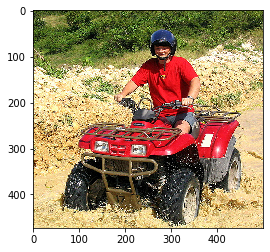

Caption:  man in red shirt is mowing lawn


In [153]:
pic_no = random.randint(0, len(test_image_names))
test_image_name = test_image_names[pic_no]

image_loc = './Flickr_Data_30k/Images/'+test_image_name+'.jpg'
x = plt.imread(image_loc)
plt.imshow(x)
plt.show()
print("Caption: ", generate_caption(image_loc, test_features))